# Positioners

The purpose of this code is to model the actual stacks of motors we have at the ID11 beamline to compute sample positions during scans. For rotation scans we need crystallographic computations to figure out if and when a $(hkl)$ reflection will appear. Assuming the reflection is found we want to compute the place where it will hit a detector. This notebook is about the diffractometer and detector geometry.

We model the instruments as a list of translations and rotations which are placed in a stack. This corresponds to the reality for simple beamline instruments. More complex geometries, like hexapods etc, are not handled. 

You can find a similar approach in the imageCIF dictionary and NEXUS positioners etc.

Also you might want to take a look at:
 https://github.com/matthew-brett/transforms3d

In the code we will have a class to represent a general positioner in terms of a 4x4 matrix:
$$ \left[ \begin{matrix} U && t \\ 0 && 1 \end{matrix} \right] $$ 
$U$ may be a rotation (or scaling or shear) and $t$ is a translation. 
In order to apply this matrix to vectors to transform them we make an augmented vector with a 1 or 0 at the end. A "1" indicates that translations are included, a "0" ignores the translations and would be suitable for pure rotations. These are needed for crystallography. e.g.:

Real space co-ordinate: 
$ \left[ \begin{matrix} x_{rot} \\ 1 \end{matrix} \right] 
      = \left[ \begin{matrix} U && t \\ 0 && 1 \end{matrix} \right] 
      \left[ \begin{matrix} x_{lab} \\ 1 \end{matrix} \right] 
      $
      
Reciprocal space vector: 
$ \left[ \begin{matrix} h_{rot} \\ 0 \end{matrix} \right] 
      = \left[ \begin{matrix} U && t \\ 0 && 1 \end{matrix} \right] 
      \left[ \begin{matrix} h_{lab} \\ 0 \end{matrix} \right] 
      $
     
The following uses the python Sympy package for doing symbolic algebra with Latex type printing. 

In [1]:
import sympy
sympy.init_printing()

Declare the symbols we are going to use below

In [2]:
x,y,z,h,k,l,t0,t1,t2,Omega,phi,W = sympy.symbols('x y z h k l t0 t1 t2 Omega phi W')
UL = sympy.symbols(" ".join(["U_%d%d"%(i,j) for i in range(3) for j in range(3)]))

Make a general matrix to begin with and also a vector

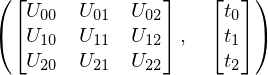

In [3]:
U = sympy.Matrix( [[UL[0],UL[1],UL[2]],
                   [UL[3],UL[4],UL[5]],
                   [UL[6],UL[7],UL[8]]])
t = sympy.Matrix( [t0,t1,t2] )
U,t

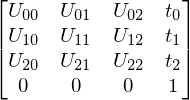

In [4]:
def make_mat4(U,t):
    mat4_full = sympy.Matrix( [[U[0,0],U[0,1],U[0,2], t[0]], 
                               [U[1,0],U[1,1],U[1,2], t[1]], 
                               [U[2,0],U[2,1],U[2,2], t[2]],  
                               [     0,     0,      0,   1]] )
    return mat4_full
mat4_full = make_mat4(U,t)
mat4_full

Some demos using a real space vector (with position) and then a reciprocal space vector (without position)

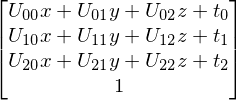

In [5]:
X = sympy.Matrix( [x,y,z,1] )  # Real space vector
mat4_full * X

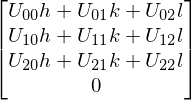

In [6]:
H = sympy.Matrix( [h,k,l,0] )
mat4_full * H     # show a reciprocal space vector picking up rotation only

The stack of motors on the beamline is then represented by a series of 4x4 matrix products. If we look for the position and orientation of the sample we put the "1" on the vector. If we only want the orientation we leave off the 1. 
Some care will be needed if these are not pure rotations.

We combine two motors, one depending on the other, as a product rule. The order of operations is important. It is not the same to translate and then rotate compared to rotate then translate. This follows in the maths as matrix multiplication does not commute.

TODO : inverse ?

Next we will generate some rotation matrices from the axis/angle representation:
 https://en.wikipedia.org/wiki/Axis%E2%80%93angle_representation
 
We implement the rotation formula. The input vector is split into 3 components. The part parallel to the axis (axis.v) and the parts perpendicular that are added as sin and cos of the angle.

In [7]:
cosOmega = sympy.cos( Omega )
sinOmega = sympy.sin( Omega )
a = sympy.Matrix( list(sympy.symbols('a0 a1 a2')))
v = sympy.Matrix( list(sympy.symbols('v0 v1 v2')))
# Wikipedia formula
vrot1 = cosOmega*v + sinOmega*(v.cross(a)) + (1-cosOmega)*(a.dot(v))*a
# Re-arrange to give:
#         perp_v_axis           perp_axis_along_v            v_along_axis
vrot2 = sinOmega*v.cross(a) + cosOmega*( v - (a.dot(v))*a) + a.dot(v)*a
# Check these two are the same thing
assert (sympy.simplify(vrot1-vrot2) == sympy.Matrix([0,0,0]))

We use the vrot1 formula then:

In [8]:

def axis_angle_rotation( vec, axis, angle ):
    """wikipedia formula"""
    cosa = sympy.cos( angle )
    sina = sympy.sin( angle )
    return cosa*vec + sina*(axis.cross(vec)) + (1-cosa)*(axis.dot(vec))*axis

Rotations around the x,y,z axes

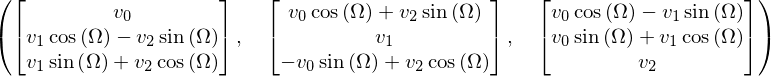

In [9]:
X = sympy.Matrix([1,0,0])
Y = sympy.Matrix([0,1,0])
Z = sympy.Matrix([0,0,1])

sympy.simplify(axis_angle_rotation(v, X, Omega)),\
sympy.simplify(axis_angle_rotation(v, Y, Omega)),\
sympy.simplify(axis_angle_rotation(v, Z, Omega))

Try to verify that we have coded a right handed rotation. It means the x transforms in +y when rotating by +90 degrees ($=\pi/2$) around z:

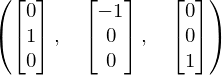

In [10]:
axis_angle_rotation( X, Z, sympy.pi/2 ),axis_angle_rotation( Y, Z, sympy.pi/2 ),axis_angle_rotation( Z, Z, sympy.pi/2 )

Now we convert the axis angle to a rotation matrix...